[-0.14650982 -0.73871557]


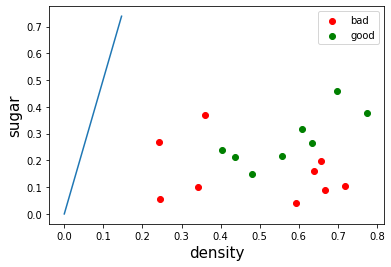

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# 西瓜数据集
# 编号,密度,含糖率,好1（坏0）瓜
data = """
1,0.697,0.46,1
2,0.774,0.376,1
3,0.634,0.264,1
4,0.608,0.318,1
5,0.556,0.215,1
6,0.403,0.237,1
7,0.481,0.149,1
8,0.437,0.211,1
9,0.666,0.091,0
10,0.243,0.267,0
11,0.245,0.057,0
12,0.343,0.099,0
13,0.639,0.161,0
14,0.657,0.198,0
15,0.36,0.37,0
16,0.593,0.042,0
17,0.719,0.103,0
"""

def get_data(data): # 这里就不划分训练和测试集
    X = [(item.split(',')) for item in data.split()]
    X = np.array(X, dtype=np.float)
    y = X[:, 3]
    X = X[:,[1,2]]
    return X, y

X, y = get_data(data)
X0, y0 = X[y==0], y[y==0]
X1, y1 = X[y==1], y[y==1]

mu0, mu1 = np.mean(X0, axis=0), np.mean(X1, axis=0)
Sw = (X0 - mu0).T.dot(X0 - mu0) + (X1 - mu1).T.dot(X1 - mu1)
w = np.linalg.inv(Sw).dot(mu0 - mu1)
print(w)

# 可视化
plt.scatter(X0[:,0], X0[:,1], c='r', label="bad")
plt.scatter(X1[:,0], X1[:,1], c='g', label="good")
plt.plot([0, -1*w[0]], [0, -1*w[1]]) # 方便显示，w同时乘-1，都是同一条直线
plt.legend()
plt.xlabel("density", fontsize=15)
plt.ylabel("sugar", fontsize=15)
plt.show()

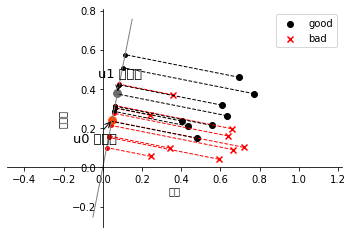

[[1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]]
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]


In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


class LDA(object):

    def fit(self, X_, y_, plot_=False):
        pos = y_ == 1
        neg = y_ == 0
        X0 = X_[neg]
        X1 = X_[pos]

        u0 = X0.mean(0, keepdims=True)  # (1, n)
        u1 = X1.mean(0, keepdims=True)

        sw = np.dot((X0 - u0).T, X0 - u0) + np.dot((X1 - u1).T, X1 - u1)
        w = np.dot(np.linalg.inv(sw), (u0 - u1).T).reshape(1, -1)  # (1, n)

        if plot_:
            fig, ax = plt.subplots()
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            ax.spines['left'].set_position(('data', 0))
            ax.spines['bottom'].set_position(('data', 0))

            plt.scatter(X1[:, 0], X1[:, 1], c='k', marker='o', label='good')
            plt.scatter(X0[:, 0], X0[:, 1], c='r', marker='x', label='bad')

            plt.xlabel('密度', labelpad=1)
            plt.ylabel('含糖量')
            plt.legend(loc='upper right')

            x_tmp = np.linspace(-0.05, 0.15)
            y_tmp = x_tmp * w[0, 1] / w[0, 0]
            plt.plot(x_tmp, y_tmp, '#808080', linewidth=1)

            wu = w / np.linalg.norm(w)

            # 正负样板店
            X0_project = np.dot(X0, np.dot(wu.T, wu))
            plt.scatter(X0_project[:, 0], X0_project[:, 1], c='r', s=15)
            for i in range(X0.shape[0]):
                plt.plot([X0[i, 0], X0_project[i, 0]], [X0[i, 1], X0_project[i, 1]], '--r', linewidth=1)

            X1_project = np.dot(X1, np.dot(wu.T, wu))
            plt.scatter(X1_project[:, 0], X1_project[:, 1], c='k', s=15)
            for i in range(X1.shape[0]):
                plt.plot([X1[i, 0], X1_project[i, 0]], [X1[i, 1], X1_project[i, 1]], '--k', linewidth=1)

            # 中心点的投影
            u0_project = np.dot(u0, np.dot(wu.T, wu))
            plt.scatter(u0_project[:, 0], u0_project[:, 1], c='#FF4500', s=60)
            u1_project = np.dot(u1, np.dot(wu.T, wu))
            plt.scatter(u1_project[:, 0], u1_project[:, 1], c='#696969', s=60)

            ax.annotate(r'u0 投影点',
                        xy=(u0_project[:, 0], u0_project[:, 1]),
                        xytext=(u0_project[:, 0] - 0.2, u0_project[:, 1] - 0.1),
                        size=13,
                        va="center", ha="left",
                        arrowprops=dict(arrowstyle="->",
                                        color="k",
                                        )
                        )

            ax.annotate(r'u1 投影点',
                        xy=(u1_project[:, 0], u1_project[:, 1]),
                        xytext=(u1_project[:, 0] - 0.1, u1_project[:, 1] + 0.1),
                        size=13,
                        va="center", ha="left",
                        arrowprops=dict(arrowstyle="->",
                                        color="k",
                                        )
                        )
            plt.axis("equal")  # 两坐标轴的单位刻度长度保存一致
            plt.show()

        self.w = w
        self.u0 = u0
        self.u1 = u1
        return self

    def predict(self, X):
        project = np.dot(X, self.w.T)

        wu0 = np.dot(self.w, self.u0.T)
        wu1 = np.dot(self.w, self.u1.T)

        return (np.abs(project - wu1) < np.abs(project - wu0)).astype(int)


if __name__ == '__main__':
    data_path = r'.\watermelon3_0_Ch.csv'

    data = pd.read_csv(data_path).values

    X = data[:, 7:9].astype(float)
    y = data[:, 9]

    y[y == '是'] = 1
    y[y == '否'] = 0
    y = y.astype(int)

    lda = LDA()
    lda.fit(X, y, plot_=True)
    print(lda.predict(X)) 
    print(y)